In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import inspect

from decision_tree import DecisionTree, ClassificationTree, TreeNode, Leaf

# Decision Tree

This notebook explains and shows the implementation of decision trees. This model can be used for both supervised classification and regression problems. In this notebook we will focus on binary classification problems, however the ideas presented here can be adapted to regression problems as well. 

The implementation can be found in __decision_tree.py__. 

## 1 Background

A decision tree can be described as a set of rules which are applied to the data sequentially in order to get a prediction. Let´s consider the data set below: 

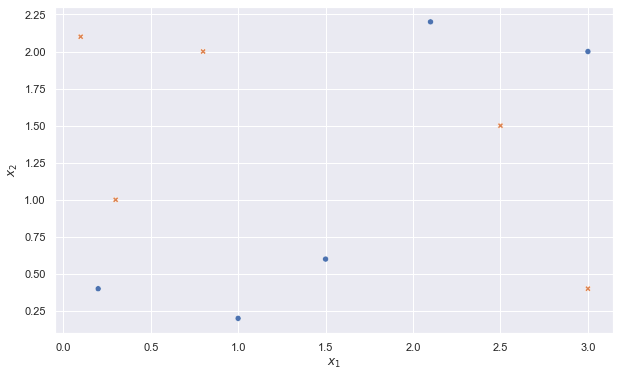

In [4]:
X = np.array([[1, 0.2], [0.2, 0.4], [1.5, 0.6], [3, 2], [2.1, 2.2], 
              [2.5, 1.5], [3, 0.4], [0.1, 2.1], [0.8, 2], [0.3, 1]])
y = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

f, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, legend=None, ax=ax)
ax.set_ylabel('$x_2$')
ax.set_xlabel('$x_1$')
plt.show()

To classify the 2 classes correctly we could draw two lines which seperates them from each other as in the figure below and then classify anything that ends up in the bottom left or top right as one class and in the other two regions as the other class.  

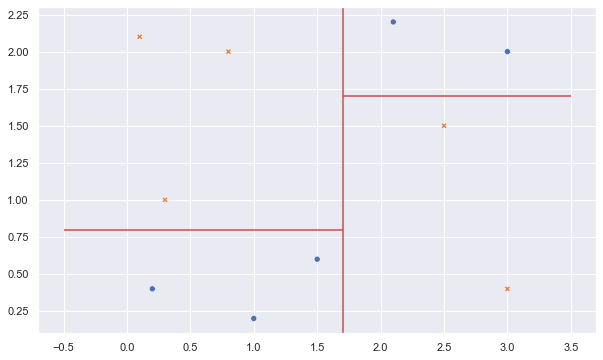

In [5]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, legend=None, ax=ax)
ax.axvline(x=1.7, color='r')
ax.hlines(y=0.8, xmin=-0.5, xmax=1.7, color='r')
ax.hlines(y=1.7, xmin=1.7, xmax=3.5, color='r')
plt.show()

## 2 Theory
Let's denote the data set by $X$ and the two partitions by $X_{left}$ and $X_{right}$. Then we want to find a feature $x_j$ and split value $c$ which leads to as pure partitions as possible given som impurity measure $J$. I.e. given the feature $x_j$ we want to find $c$ such that 

\begin{equation}
\label{eq:splitval}
\underset{c}{\min}\overset{m}{\underset{i=1}{\sum}} (J(y^{(i)})\unicode{x1D7D9}_{\{x^{(i)} \in X_{left}\}} +
   J(y^{(i)})\unicode{x1D7D9}_{\{x^{(i)} \in X_{right}\}})
\end{equation}
where $X_{left} = \{X^{(i)} : X_j^{(i)} \leq c\}$ and $X_{right} = \{X^{(i)} : X_j^{(i)} > c\}$.

Thus the problem of finding the two partitions can be formulated as 

$$\underset{j}{\min}\underset{c}{\min}\overset{m}{\underset{i=1}{\sum}} (J(y^{(i)})\unicode{x1D7D9}_{\{x^{(i)} \in X_{left}\}} +
   J(y^{(i)})\unicode{x1D7D9}_{\{x^{(i)} \in X_{right}\}})$$

The choice of impurity measure depends on if the problem is a classification problem or a regression problem. In the latter case the mean squared error can be used, i.e. 
$$J(y^{(i)}, \hat{y}^{(i)}) = (y^{(i)} - \hat{y}^{(i)})^2$$

For classification problem we can use the gini impurity 
$$J_{gini} = \underset{k=1}{\overset{K}{\sum}}\hat{p}_k (1 - \hat{p}_k)$$
or the entropy impurity
$$J_{entropy} = \underset{k=1}{\overset{K}{\sum}}\hat{p}_k \log(\hat{p}_k)$$
where $K$ is the number of classes and $\hat{p}_k$ is the fraction ..., i.e. $\hat{p}_k = $.

In this example we will only consider _binary_ classification problems and thus the entropy and gini impurity can be reduced to 
$$J_{gini} = 2\hat{p}(1-\hat{p})$$
and
$$J_{entropy} = \hat{p}\log(1-\hat{p}) + (1-\hat{p}^{(i)})\log(\hat{p})$$

For more details please refer to [1].

## 3 Implementation
This implementation of decision trees consists of three main steps:
1. Implement functions to find which feature to split and at which value to make the split.
2. Define a structure by which a tree can be represented.
3. Implement a way to traverse the grown tree to be able to make predictions.

### 3.1 Split step

#### 3.1.1 Find split value

To implement the split step of the algorithm let's first consider the step of finding a split value given a feature $x_i$. This is implemented in the `find_split` method of the `DecisionTree` class and is defined as followed:

In [6]:
print(inspect.getsource(DecisionTree.find_split))

    def find_split(self, feature, y):
        """Find best split.

        Find the best split given the values for the provided feature.

        Parameters
        ----------
        feature : ndarray
            An column vector with the values for one feature. Should be of
            shape (m,).
        y : ndarray
            A column vector with the true labels for the column vector
            `feature`. Should be of shape (m,).

        Returns
        -------
        cost_low : float
            The lowest cost that can be achieved by splitting the feature at
            the value `best_split`.
        best_split : float
            The value in `feature` which is the best split, i.e. the split that
            minimize the cost.
        """
        idx_sorted = np.argsort(feature)
        feature = feature[idx_sorted]
        y = y[idx_sorted]
        cost_low = np.inf
        best_split = None
        for v in np.unique(feature)[:-1]:
            r1 = y[feature <= v]
      

The rational behind `find_split` is as follows:
1. Sort the array `feature` in ascending order and sort the array `y` in corresponding order.
2. Initialize the variables `cost_low=np.inf` and `best_split=None`.
3. Loop through each of the values in the sorted array `feature` and split `y` into two parts `r1` and `r2`. Compute the impurity for the split and update the variables `cost_low` and `best_split` if the split yields a better split. Note that the `best_split` will not be updated to the actual split value but to the average of the split value and the following value in the the array `feature`. 

The method `find_split` works for both regression and classification problems. The only thing that differs is how the impurity is calculated. Let´s look at the `eval_split` method that is used in `find_split` to compute the impurity measure for classification problems.

In [7]:
print(inspect.getsource(ClassificationTree.eval_split))

    def eval_split(self, y_left, y_right):
        """Evaluate a candidate split.

        y_left : ndarray
            The true target value for one of the two partitions. Should be of
            shape (n_left,).
        y_right : ndarray
            The true target value for one of the two partitions. Should be of
            shape (n_right,).

        Returns
        -------
        float
            The value of the impurity measure for the given split.
        """
        p_left = np.mean(y_left, keepdims=True)
        p_right = np.mean(y_right, keepdims=True)
        if self.impurity_measure == 'gini':
            c_left = gini(p_left)
            c_right = gini(p_right)
        else:
            c_left = enropy(p_left)
            c_right = enropy(p_right)
        n_left = y_left.shape[0]
        n_right = y_right.shape[0]
        n = n_left + n_right
        return (n_left / n) * c_left + (n_right / n) * c_right



The structure of the `eval_split` method is the following:
1. Compute the mean of the target variable in each of the two partitions `y_left` and `y_right`. 
2. Compute the cost of the split given an impurity measure. 
3. Add the cost for each parition by weighting them by the fraction of records in the partition.

#### 3.1.2 Find feature
Now that we have defined how to find the best split value given a choice of feature, we can define how to find the best feature to use for the split. This is implemented in the method `find_feature` of the `DecisionTree` class and is defined as follows: 

In [8]:
print(inspect.getsource(DecisionTree.find_feature))

    def find_feature(self, X, y):
        """Find a feature to split.

        Parameters
        ----------
        X : ndarray
        y : ndarray

        Returns
        -------
        best_feature : int
            The index of the best feature to split.
        best_split : float
            The best value to split at.
        """
        cost_low = np.inf
        best_feature = None
        best_split = None
        for i in range(X.shape[1]):
            cost, split_val = self.find_split(X[:, i], y)
            if cost < cost_low:
                best_feature = i
                best_split = split_val
                cost_low = cost
        return best_feature, best_split



1. The variables `cost_low`, `best_feature` and `best_split` is initialized.
2. Loop through each feature in the input data `X` and find the best split value for that feature by calling the `find_split` method.
3. If this yields a better split than before, update the variables `best_feature` and `best_split`.

### 3.2 Building a tree

Now we have an implementation for finding the best split given a data set `X`. Thus to build the whole tree we only need to iteratively call the method `find_feature` until all of the regions are pure. However, to be able to make a prediction when the tree is fitted to data we need a way of keeping track of all the features, split values and in which order they should be applied. Therefore, before implementing our `partition` method let´s implement two classes `TreeNode` and `Leaf` which we can use to represent the fitted tree. 

First let´s implement the class `TreeNode` as shown below. This class only keep record of which feature and at what value that feature should be split at a node in the tree. Also, it keep record of which the left and right child is in the tree which makes it possible to traverse the tree when it is fitted. 

In [9]:
print(inspect.getsource(TreeNode))

class TreeNode(object):
    """
    This implements a node in a tree which is not a leaf. It is used to store
    information about which feature to split and at which value.

    Attributes
    ----------
    feature : int
    split_val : float
    left_child : TreeNode instance or Leaf instance
    right_child : TreeNode instance or Leaf instance
    """
    def __init__(self, feature, split_val, left_child, right_child):
        self.feature = feature
        self.split_val = split_val
        self.left_child = left_child
        self.right_child = right_child



The implementation of the `Leaf` class is even simpler and does only keep record of one thing, the prediction value or predicted class at that node.

In [10]:
print(inspect.getsource(Leaf))

class Leaf(object):
    """Leaf node.

    This implements a leaf node in a tree which is used to store predictions.

    Attributes
    ----------
    pred : int
        The predicted label for an observation which ends up in this leaf.
    """
    def __init__(self, pred):
        self.pred = int(pred)



Now that we have a way to represent a tree we can define the method `fit` which will fit a tree given a data set `X` and target variable `y` using the `partition` method. It´s implemented as follows:

1. If the input data `y` only contains one label, then the node is pure and `X` cannot be split any further. Therefore a `Leaf` instance is returned with the `prediction` attribute set to the unique label in `y`. This step is performed in the `check_partition` method.
2. If we are not at a leaf node, find the best feature to split at and the split value. 
3. Divide the input data `X` and `y` into two parts at the split value for the selected feature.
4. This will continue until the tree is fully grown.


In [11]:
print(inspect.getsource(DecisionTree.fit))

    def fit(self, X, y):
        """Fit a decision tree model to the data.

        Parameters
        ----------
        X : ndarray
            A matrix with the training data.
        y : ndarray
            A column vector with the true target values.

        Returns
        self
        """
        self.root = self.partition(X, y)
        return self



In [12]:
print(inspect.getsource(DecisionTree.partition))

    def partition(self, X, y, depth=0):
        """Partition the data.

        Parameters
        ----------
        X : ndarray
            A matrix with the data.
        y : ndarray
            A column vector with the true target values.
        depth : int
            The maximum depth of the tree to grow.

        Returns
        -------
        node : TreeNode instance
            A node which represents the root of the fitted tree.
        """
        check = self.check_partition(y, depth)
        if isinstance(check, Leaf):
            return check

        feature, split_val = self.find_feature(X, y)
        X_left = X[X[:, feature] <= split_val]
        X_right = X[X[:, feature] > split_val]
        y_left = y[X[:, feature] <= split_val]
        y_right = y[X[:, feature] > split_val]

        node = TreeNode(feature, split_val, self.partition(X_left, y_left, depth+1),
                        self.partition(X_right, y_right, depth+1))
        return node



In [13]:
print(inspect.getsource(ClassificationTree.check_partition))

    def check_partition(self, y, depth):
        """Check if `y` only contains one class or if the maximum depth is
        reached.

        Parameters
        ----------
        y : ndarray
            An array with class labels.
        depth : int
            The maximum depth of the tree.

        Returns
        -------
        check : Leaf instance or None
            A Leaf instance is returned if either `y` only contains one class
            label or if the maximum depth of the tree is reached. Otherwise,
            None is returned.
        """
        (y_unique, counts) = np.unique(y, return_counts=True)

        if len(y_unique) == 1:
            return Leaf(y_unique)

        if self.max_depth is None:
            return None
        elif depth >= self.max_depth:
            idx = np.argmax(counts)
            val = y_unique[idx]
            return Leaf(val)
        else:
            return None



### 3.3 Predictions

We now have an implemention which can be used for fitting a decision tree to a data set. However, we also want to be able to predict new instances of data and we therefore need to implement a `predict` method. To be able to make predictions we need a way to traverse our fitted tree and thus we begin with implementing a `traverse` method. The `traverse` method is a recursive method and will return a prediction when it has gotten to a lead node of the tree.

The rational behind the `traverse` method is the following:
1. Check if the parameter `node` is a `Leaf`instance. If so we have found a leaf node and we can return its attribute `prediction`. 
2. Otherwise, the node is a `TreeNode` and we can access its attributes `feature` and `split_val` to decide if we should call the `traverse` method for the left or right child of the given node. 

In [14]:
print(inspect.getsource(DecisionTree.traverse))

    def traverse(self, X, node):
        """Traverse the tree.

        Parameter
        ---------
        X : ndarray
            A single row of data.
        node: TreeNode instance
            The node should be the root of the tree.

        Returns
        -------
        pred : float
            The prediction for row `X`.
        """
        if isinstance(node, Leaf):
            return node.pred
        if X[node.feature] <= node.split_val:
            return self.traverse(X, node.left_child)
        else:
            return self.traverse(X, node.right_child)



Now the only thing that remains is to define our `predict` method which will call the `traverse` method with the root of the tree as the input `node`.

In [15]:
print(inspect.getsource(DecisionTree.predict))

    def predict(self, X, y=None):
        """Predict the target for a data row `X`.

        Parameters
        ----------
        X : ndarray
            A data row of shape (n_features,).

        Returns
        -------
        pred : float or int
            Prediction for the data row `X`.
        """
        pred = np.zeros(shape=(X.shape[0], 1))
        for i in range(X.shape[0]):
            pred[i] = self.traverse(X[i, :], self.root)
        return pred



## 4 Test the implementation

Now we should have a fully functional implementation of a decision tree. Let´s test it on some generated data sets.

In [16]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [17]:
from sklearn.tree import DecisionTreeClassifier

First lets start with a trivial data set with two classes. As shown in the figure below these two classes should be easily seperatable with one split through the x-axis. 

In [18]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=1,
                           class_sep=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

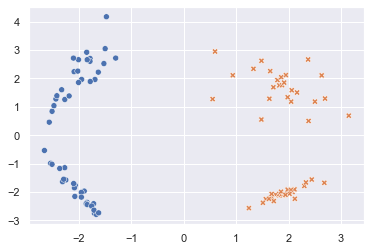

In [19]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, legend=None)
plt.show()

As seen in the figure below the algorithm find one split between -1 and 0 through the x-axis which perfectly partition the data set. 

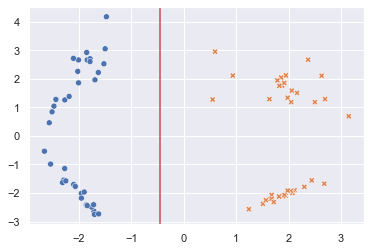

In [20]:
tree = ClassificationTree()
tree.fit(X_train, y_train)
tree.plot_boundaries(X_train, y_train)

Now let's try with a data set with two classes but in which the data overlaps.

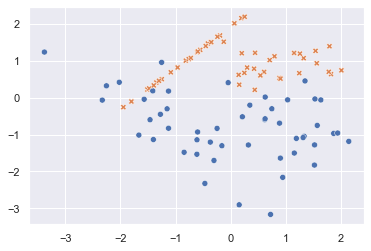

In [21]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=9,
                           class_sep=0.9)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, legend=None)
plt.show()

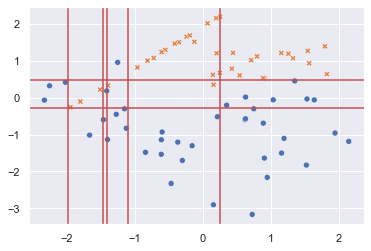

In [22]:
tree = ClassificationTree()
tree.fit(X_train, y_train)
tree.plot_boundaries(X_train, y_train)

As seen the previous example, the tree is grown until all leafs are pure. Let's try out `max_depth=1` and see what effect it has on the algorithm. 

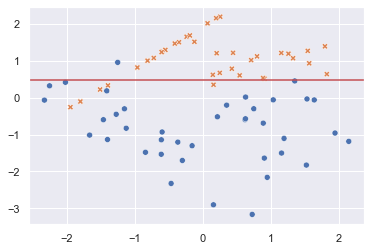

In [23]:
tree = ClassificationTree(max_depth=1)
tree.fit(X_train, y_train)
tree.plot_boundaries(X_train, y_train)

When setting `max_depth=1` the tree will only make one split. For this simple data set it seems to giver rather good results.

## 5. References

[1] T. Hastie, R. Tibshirani and J. H. Friedman, _The elements of statistical learning: data mining, inference, and
prediction_. New York: Springer, 2 ed., 2009. 